In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as rfc
from scipy.ndimage import gaussian_filter
%matplotlib inline

/epyc/opt/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Machine Learning Classifier Attemps for KBMOD

## Make training set

### False Dataset

Our false data is a set of postage stamps actually collected from KBMOD that were false positives coming through the pipeline. These were obtained when recovering known objects in Pointing Group 010 to 089 in the Lori Allen NEO dataset

In [2]:
full_false = np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamp_training_set.npy')

### Make real dataset

Make some real Gaussians and add noise to use as truth for training. Add them to a background from real images and searched along a trajectory. Add some scatter in the alignment and some variance to the PSF size.

In [30]:
import os
from astropy.io import fits
import matplotlib.dates as mdates
import datetime as dt
from dateutil.parser import parse
import multiprocessing as mp
import pickle

with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointings.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)

# Import the times
times=[[]]*len(Pointing_Groups)
for i,pointing in enumerate(Pointing_Groups):
    times[i]=np.array([0.]*len(Pointing_Groups[i]['date_obs']))
    for j in range(len(Pointing_Groups[i]['date_obs'])):
        foo = parse(Pointing_Groups[i]['date_obs'][j])
        times[i][j]= foo.timestamp()
        
def makeSyntheticCoadd(pgccd):
    """
    This function generates a synthetic coadd for a given pointing group and ccd.
    It generates a random trajectory along the visits and uses those to get 21x21
    pixel stamps. It puts a gaussian with a semi-random PSF in each stamp, with
    some scatter for the central pixel. It adds a linear offset to the stamps.
    It then returns the median of all the stamps.
    """
    pg_num = pgccd[0]
    ccd = pgccd[1]
    visit_list = Pointing_Groups[pg_num]['visit_id']
    cutout_size = 21 # pixels
    speed_lims = [100,300] # px/day
    ang_lims = [0,np.pi/2] # radians
    time_baseline = (times[pg_num][-1]-times[pg_num][0])/(3600*24) # days
    
    # Set a 2 pixel potential velocity offset
    max_x_vel_offset = 4*(0.5-np.random.random())
    max_y_vel_offset = 4*(0.5-np.random.random())
    visit_num = len(visit_list)
    
    if ccd==2 or ccd==61:
        return([])
    pg_object_list = []
    for i,visit_id in enumerate(visit_list):
        net_x_offset = (1-2*np.random.random())/2
        net_y_offset = (1-2*np.random.random())/2
        imagePath = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{:03d}'
        diffPath = os.path.join(imagePath.format(pg_num),'warps/{:02d}/{}.fits'.format(int(ccd),visit_id))
        try:
            hdul = fits.open(diffPath)
        except:
            continue
        data = hdul[1].data
        # Compute the values of various parameters for this specific stamp.
        # Uses the limits defined above.
        data_size = np.shape(data)
        speed = (speed_lims[1]-speed_lims[0]) * np.random.random() + speed_lims[0]
        angle = (ang_lims[1]-ang_lims[0]) * np.random.random() + ang_lims[0]
        vel = [speed*np.cos(angle), speed*np.sin(angle)]
        starting_pixel_xy_max = [data_size[1] - 100 - speed*time_baseline, data_size[0] - 100 - speed*time_baseline]
        start_px = [50+starting_pixel_xy_max[0]*np.random.random(), 50+starting_pixel_xy_max[1]*np.random.random()]
        min_gauss_sigma = 1
        brightness_lims = [150,4000]
        object_brightness = (brightness_lims[1]-brightness_lims[0])*np.random.random() + brightness_lims[0]
        elapsed_time = (times[pg_num][i] - times[pg_num][0])/(3600*24)
        pixel = [start_px[0]+vel[0]*elapsed_time, start_px[1]+vel[1]*elapsed_time]
        min_x = int(pixel[0]-(cutout_size-1)/2)-1
        max_x = int(pixel[0]+(cutout_size-1)/2)
        min_y = int(pixel[1]-(cutout_size-1)/2)-1
        max_y = int(pixel[1]+(cutout_size-1)/2)
        cutout = np.copy(data[min_y:max_y,min_x:max_x])
        cutout[np.isnan(cutout)] = 0
        #cutout -= np.min(cutout)
        #cutout /= np.sum(cutout)
        cutout_edge = (cutout_size-1)/2                                                   
        x = np.linspace(-cutout_edge, cutout_edge, cutout_size)
        y = np.linspace(-cutout_edge, cutout_edge, cutout_size)
        x, y = np.meshgrid(x, y)
        sigma = np.random.random()+min_gauss_sigma
        gaussian_kernel = (object_brightness * (1/(2*np.pi*sigma*sigma) 
            * np.exp(-((x-net_x_offset-max_x_vel_offset*(i/visit_num))**2/(2*sigma**2) + (y-net_y_offset-max_y_vel_offset*(i/visit_num))**2/(2*sigma**2))))
            * (1+(0.1*(np.random.random(cutout_size*cutout_size).reshape(cutout_size,cutout_size)-0.5)))) # add 3% noise to psf)
        #sim_object = np.zeros((cutout_size, cutout_size))
        #sim_object[int((cutout_size-1)/2), int((cutout_size-1)/2)] = object_brightness
        #sim_object = gaussian_filter(sim_object, np.random.random()+min_gauss_sigma)
        sim_object = cutout + gaussian_kernel
        pg_object_list.append(sim_object)
    if len(pg_object_list)>0:
        median_coadd = np.median(pg_object_list, axis=0)
    else:
        median_coadd = []
    return(median_coadd)

In [ ]:
# Generate the stamps using the above function.
# This will take a while (approx. 2 hours)
all_results = []
pg_list = np.linspace(91,110,20).astype(int)
foo = np.linspace(1,62,62).astype(int)
foo = foo[foo!=2]
ccd_list = foo[foo!=61]
pgccd_list = []
for pg in pg_list:
    for ccd in ccd_list:
        pgccd_list.append([pg,ccd])
with mp.Pool(20) as pool:
    for j in range(50):
        results = pool.map(makeSyntheticCoadd, pgccd_list)
        all_results.append(results)

In [34]:
# Save the stamps
all_coadd_stamps = np.concatenate(all_results, axis=0)
np.save('stamps_simulated.npy', all_coadd_stamps)

In [364]:
full_true=np.load('stamps_simulated_v3.npy')

## Train the CNN

In [3]:
# based on https://github.com/pytorch/examples/blob/master/mnist/main.py

import argparse
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
learning_curve = []
validation_lc = []
output_probs = []
class Net(nn.Module):
    def __init__(self,bn_mom=0.5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.bn2 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(2*2*50,500)
        self.fc2 = nn.Linear(500,2)
        self.dropout = nn.Dropout2d(p=0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.conv1(x))))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 2*2*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class KbmodDataSet(Dataset):
    def __init__(self, data_tensor):
        self.current_data = data_tensor
        
    def __getitem__(self, index):
        return self.current_data[index] #(img, label)

    def __len__(self):
        return len(self.current_data)
    
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        learning_curve.append(loss.item())


def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, torch.float), target.to(device)
            output = model(data)
            output_probs.append(np.copy(output.cpu().detach().numpy()))
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    validation_lc.append(test_loss)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
def main(seed=1, batch_size=64, test_batch_size=1000, lr=0.01, momentum=0.5, no_cuda=False, save_model=False, epochs=10, log_interval=25):

    path = './'
    rand_state = np.random.RandomState(777)
    simulated_positives = np.load(path+'stamps_simulated.npy').astype(float)
    fake_positives = []
    for stamp in simulated_positives:
        stamp -= np.min(stamp)
        stamp /= np.sum(stamp)
        fake_positives.append(stamp)
    fake_positives = np.array(fake_positives)
    false_positives = np.load(path+'stamp_training_set.npy').astype(float)
    np.random.shuffle(fake_positives)
    np.random.shuffle(false_positives)
    
    full_dataset = [(torch.from_numpy(np.array([x])), 1) for x in fake_positives] + \
               [(torch.from_numpy(np.array([x])), 0) for x in false_positives]
    
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.2 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        KbmodDataSet(train_dataset), batch_size=batch_size, shuffle=True, **kwargs)

    val_loader = torch.utils.data.DataLoader(
        KbmodDataSet(val_dataset), batch_size=test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(1, epochs + 1):
        train(log_interval, model, device, train_loader, optimizer, epoch)
        validate(model, device, val_loader)

    if (save_model):
        #torch.save(model.state_dict(),"kbmod_cnn.pt")
        torch.save(model,"./kbmod_cnn_background_v500.pt")
    del(model)
    del(train_dataset)
    del(val_dataset)
    del(test_dataset)

In [ ]:
model = main(save_model=True, lr=0.005, batch_size=8192, test_batch_size=8192, momentum=0.10, epochs=200)

Train Epoch: 1 [0/76984 (0%)]	Loss: 0.696883

Validation set: Average loss: 0.6901, Accuracy: 12385/21995 (56%)

Train Epoch: 2 [0/76984 (0%)]	Loss: 0.690900

Validation set: Average loss: 0.6883, Accuracy: 12599/21995 (57%)

Train Epoch: 3 [0/76984 (0%)]	Loss: 0.673898

Validation set: Average loss: 0.6872, Accuracy: 12632/21995 (57%)

Train Epoch: 4 [0/76984 (0%)]	Loss: 0.687719

Validation set: Average loss: 0.6860, Accuracy: 12707/21995 (58%)

Train Epoch: 5 [0/76984 (0%)]	Loss: 0.668536

Validation set: Average loss: 0.6852, Accuracy: 12712/21995 (58%)

Train Epoch: 6 [0/76984 (0%)]	Loss: 0.673245

Validation set: Average loss: 0.6847, Accuracy: 12689/21995 (58%)

Train Epoch: 7 [0/76984 (0%)]	Loss: 0.685130

Validation set: Average loss: 0.6838, Accuracy: 12739/21995 (58%)

Train Epoch: 8 [0/76984 (0%)]	Loss: 0.673459

Validation set: Average loss: 0.6833, Accuracy: 12723/21995 (58%)

Train Epoch: 9 [0/76984 (0%)]	Loss: 0.676691

Validation set: Average loss: 0.6841, Accuracy: 12

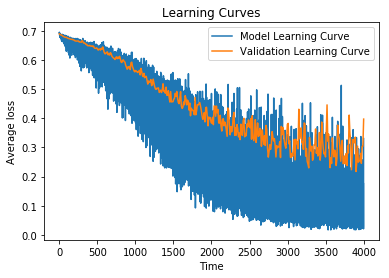

In [4]:
# Plot the learning curves and output probability from the last validation batch
import matplotlib.pyplot as plt
valid_lc_x = np.linspace(0,len(learning_curve),len(validation_lc))
plt.plot(learning_curve)
plt.plot(valid_lc_x,validation_lc)
plt.ylabel('Average loss')
plt.xlabel('Time')
plt.title('Learning Curves')
plt.legend(['Model Learning Curve','Validation Learning Curve'])
#plt.savefig('Learning_curve_400e.png')

plt.figure()
_=plt.hist(np.e**output_probs[-1][:,1])
plt.xlabel('Predicted probability of being a real object')

## Below is old work on a random forest classifier. It is no longer being used.

In [365]:
train_true = full_true[:40000]
test_true = full_true[40000:]

### Merge true and false into full training and test sets

In [366]:
train_set = []
rand_state = np.random.RandomState(1302)
rand_idx = np.arange(80000)
rand_state.shuffle(rand_idx)
train_class = []
for idx in rand_idx:
    if idx < 40000:
        train_set.append(train_false[idx].flatten())
        train_class.append(0)
    else:
        train_set.append(train_true[idx-40000].flatten())
        train_class.append(1)

In [367]:
test_set = []
rand_idx = np.arange(9978+10005)
rand_state.shuffle(rand_idx)
test_class = []
for idx in rand_idx:
    if idx < 9978:
        test_set.append(test_false[idx].flatten())
        test_class.append(0)
    else:
        test_set.append(test_true[idx-9978].flatten())
        test_class.append(1)

## Train Classifier

In [368]:
rand_rfc_state = np.random.RandomState(345)
rfc_kbmod = rfc(n_estimators=100, random_state=rand_rfc_state)

In [369]:
rfc_kbmod.fit(train_set, train_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f79ec7c1e58>,
            verbose=0, warm_start=False)

In [371]:
test_results = rfc_kbmod.predict(test_set)

(array([19981.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

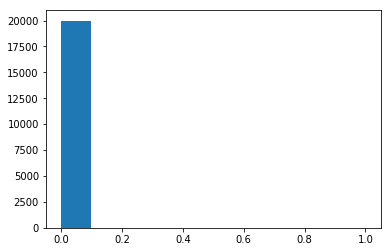

In [372]:
plt.hist(test_class - test_results,range=[0,1])

In [373]:
test_probs = rfc_kbmod.predict_proba(test_set)

In [374]:
fpr = []
tpr = []
for cutoff in np.arange(0.01, 1.0, 0.01):
    correct_false = []
    correct_true = []
    false_positive = []
    false_negative = []
    index = 0
    for true_class, result_prob in zip(test_class, test_probs):
        if true_class == 0.:
            if result_prob[0] > cutoff:
                correct_false.append(index)
            else:
                false_positive.append(index)
        else:
            if result_prob[0] > cutoff:
                false_negative.append(index)
            else:
                correct_true.append(index)
        index+=1
    fpr.append(len(false_positive)/10005)
    tpr.append(len(correct_true)/10005)

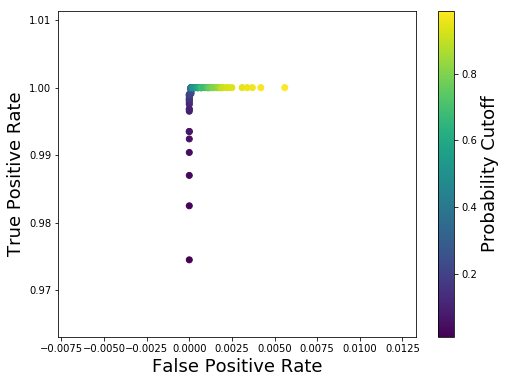

In [375]:
fig = plt.figure(figsize=(8,6))
plt.scatter(fpr, tpr, c=np.arange(0.01, 1.0, 0.01))
cbar = plt.colorbar()
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
cbar.set_label('Probability Cutoff', size=18)

If we set our cutoff to 0.89 we don't lose any trues. Let's see how this performs

In [376]:
correct_false = []
correct_true = []
false_positive = []
false_negative = []
index = 0
cutoff = 0.89
for true_class, result_prob in zip(test_class, test_probs):
    if true_class == 0.:
        if result_prob[0] > cutoff:
            correct_false.append(index)
        else:
            false_positive.append(index)
    else:
        if result_prob[0] > cutoff:
            false_negative.append(index)
        else:
            correct_true.append(index)
    index+=1

In [377]:
57/10005

0.005697151424287856

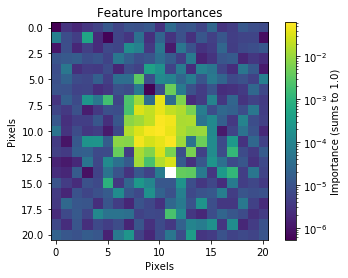

In [378]:
plt.imshow(rfc_kbmod.feature_importances_.reshape(21,21), norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.title('Feature Importances')
cbar.set_label('Importance (sums to 1.0)')

In [379]:
test_total = np.array([test_class, test_results]).T

In [380]:
results_df = pd.DataFrame(test_total, columns=['True Class', 'Predicted Class'])

In [381]:
rfc_results = np.array([[len(correct_true), len(false_positive)], [len(false_negative), len(correct_false)]])

([<matplotlib.axis.YTick at 0x7f798f945080>,
 <a list of 2 Text yticklabel objects>)

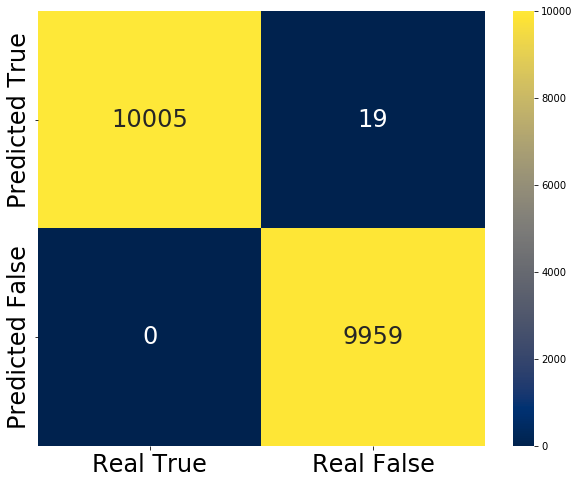

In [382]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(rfc_results, annot=True, annot_kws={'size':24}, cmap=plt.get_cmap('cividis'), fmt='g')
plt.xticks([0.5, 1.5], ['Real True', 'Real False'], size=24)
plt.yticks([0.5, 1.5], ['Predicted True', 'Predicted False'], size=24, va='center')

### Look at False Negatives and False Positives

IndexError: list index out of range

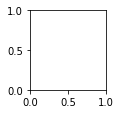

In [412]:
fig = plt.figure(figsize=(16, 12))
for i in range(69):
    fig.add_subplot(7, 10, i+1)
    plt.imshow(test_set[false_negative[i]].reshape(21,21))
    plt.title(test_probs[false_negative[i]])
plt.suptitle('False Negatives')

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


IndexError: list index out of range

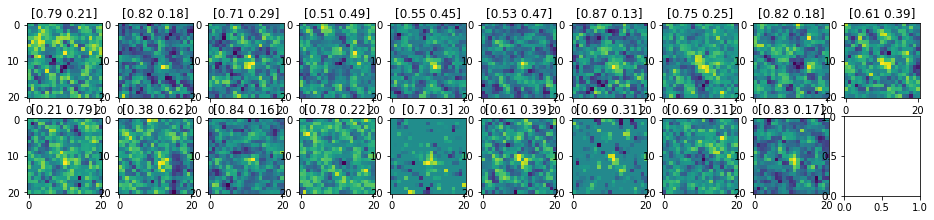

In [383]:
fig = plt.figure(figsize=(16, 12))
for i in range(70):
    fig.add_subplot(7, 10, i+1)
    plt.imshow(test_set[false_positive[i]].reshape(21,21))
    plt.title(test_probs[false_positive[i]])
plt.suptitle('False Negatives')
plt.tight_layout()

## Save Model

In [384]:
import pickle

In [385]:
filename = 'rfc_kbmod.model'
pickle.dump(rfc_kbmod, open(filename, 'wb'))